#### Objective: predict 28 days, from d_1942 to d_1969

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

import gc

import dask
import dask.dataframe as dd
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

# Create a Dask Cluster with one worker per GPU
cluster = LocalCUDACluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41765 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 16.66 GB


In [2]:
dask.config.config

{'temporary-directory': None,
 'dataframe': {'shuffle-compression': None},
 'array': {'svg': {'size': 120},
  'chunk-size': '128MiB',
  'rechunk-threshold': 4},
 'optimization': {'fuse': {'active': True,
   'ave-width': 1,
   'max-width': None,
   'max-height': inf,
   'max-depth-new-edges': None,
   'subgraphs': None,
   'rename-keys': True}},
 'distributed': {'version': 2,
  'scheduler': {'allowed-failures': 3,
   'bandwidth': 100000000,
   'blocked-handlers': [],
   'default-data-size': '1kiB',
   'events-cleanup-delay': '1h',
   'idle-timeout': None,
   'transition-log-length': 100000,
   'work-stealing': True,
   'work-stealing-interval': '100ms',
   'worker-ttl': None,
   'pickle': True,
   'preload': [],
   'preload-argv': [],
   'unknown-task-duration': '500ms',
   'default-task-durations': {'rechunk-split': '1us', 'shuffle-split': '1us'},
   'validate': False,
   'dashboard': {'status': {'task-stream-length': 1000},
    'tasks': {'task-stream-length': 100000},
    'tls': {'ca-

### Load & Check Datasets

In [3]:
sales = dd.read_csv("INPUT/sales_train_evaluation.csv")
print(len(sales),",", len(sales.columns))
sales.head()

30490 , 1947


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [4]:
#as they ask us to predict 1942-1969 days we need this days in sales
for d in range(1942,1970):
    sales["d_" + str(d)] = int(0)

In [5]:
sales.isnull().sum().compute().any()

False

In [6]:
calendar = dd.read_csv("INPUT/calendar.csv")
print(len(calendar),",", len(calendar.columns))
calendar.head()

1969 , 14


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [7]:
calendar.isnull().sum().compute()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [8]:
calendar = calendar.fillna("no event")

In [9]:
price = dd.read_csv("INPUT/sell_prices.csv")
print(len(price),",", len(price.columns))
price.head()

6841121 , 4


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [10]:
price.isnull().sum().compute()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

### Downcasting

In [11]:
sales.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 1975 entries, id to d_1969
dtypes: object(6), int64(1969)

In [12]:
calendar.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 14 entries, date to snap_WI
dtypes: object(7), int64(7)

In [13]:
price.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 4 entries, store_id to sell_price
dtypes: object(2), float64(1), int64(1)

In [14]:
sales = sales.compute()
calendar = calendar.compute()
price = price.compute()

In [15]:
from skmem import MemReducer

mr = MemReducer()

sales = mr.fit_transform(sales)
calendar = mr.fit_transform(calendar)
price = mr.fit_transform(price)

Memory in: 470.04 MB
Starting integers.
Starting objects.
Memory out: 68.26 MB
Reduction: 85.5%
Memory in: 0.96 MB
Starting integers.
Starting objects.
Memory out: 0.27 MB
Reduction: 71.3%
Memory in: 1009.71 MB
Starting integers.
Starting objects.
Memory out: 137.29 MB
Reduction: 86.4%


In [16]:
sales = dd.from_pandas(sales, npartitions=8)
calendar = dd.from_pandas(calendar, npartitions=8)
price = dd.from_pandas(price, npartitions=8)

In [17]:
sales.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 1975 entries, id to d_1969
dtypes: category(1), category(1), category(1), category(1), category(1), object(1), uint16(269), uint8(1700)

In [18]:
#we will change date to datetime, otherwise pyplot will take it as a string a won't plot it as time series
calendar.date = dd.to_datetime(calendar.date)

calendar.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 14 entries, date to snap_WI
dtypes: category(1), category(1), category(1), category(1), category(1), datetime64[ns](1), object(1), uint16(2), uint8(5)

In [19]:
price.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 4 entries, store_id to sell_price
dtypes: category(1), category(1), float64(1), uint16(1)

### Melting & Merging 

In [20]:
#melt will take all id_vars, and the rest will be transpossed in 1 column, which in this case is perfect
sales = dd.melt(sales, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 
                                           'state_id'], var_name = 'd', value_name = 'sales')
print(len(sales),",",len(sales.columns))
sales.head()

60034810 , 8


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOUSEHOLD_1_220_TX_2_evaluation,HOUSEHOLD_1_220,HOUSEHOLD_1,HOUSEHOLD,TX_2,TX,d_1,0
2,HOUSEHOLD_1_221_TX_2_evaluation,HOUSEHOLD_1_221,HOUSEHOLD_1,HOUSEHOLD,TX_2,TX,d_1,0
3,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [21]:
sales_cal = dd.merge(sales, calendar, on="d", how="left")

In [22]:
df = dd.merge(sales_cal, price, on=["store_id", "item_id", "wm_yr_wk"], how="left")

In [23]:
#freeing up space
del sales, calendar, price, sales_cal
collected = gc.collect()
print("Garbage Collector collected:", collected, "elements")

Garbage Collector collected: 104 elements


In [24]:
print(len(df),",",len(df.columns))
%time df.head()

60034810 , 22
CPU times: user 3.05 s, sys: 392 ms, total: 3.44 s
Wall time: 2min 27s


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOUSEHOLD_1_223_TX_2_evaluation,HOUSEHOLD_1_223,HOUSEHOLD_1,HOUSEHOLD,TX_2,TX,d_2,0,2011-01-30,11101,...,1,2011,no event,no event,no event,no event,0,0,0,NaN
1,HOUSEHOLD_1_224_TX_2_evaluation,HOUSEHOLD_1_224,HOUSEHOLD_1,HOUSEHOLD,TX_2,TX,d_2,0,2011-01-30,11101,...,1,2011,no event,no event,no event,no event,0,0,0,8.97
2,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,11101,...,1,2011,no event,no event,no event,no event,0,0,0,0.46
3,HOBBIES_1_011_CA_1_evaluation,HOBBIES_1_011,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,...,1,2011,no event,no event,no event,no event,0,0,0,NaN
4,HOUSEHOLD_1_235_TX_2_evaluation,HOUSEHOLD_1_235,HOUSEHOLD_1,HOUSEHOLD,TX_2,TX,d_2,2,2011-01-30,11101,...,1,2011,no event,no event,no event,no event,0,0,0,3.28


In [25]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 22 entries, id to sell_price
dtypes: category(1), category(1), category(1), category(1), category(1), category(1), category(1), category(1), category(1), category(1), datetime64[ns](1), object(2), float64(1), uint16(3), uint8(5)

### Choosing Final Distribution

In [26]:
cat = df.cat_id.value_counts().compute()
cat

FOODS        28294530
HOUSEHOLD    20615430
HOBBIES      11124850
Name: cat_id, dtype: int64

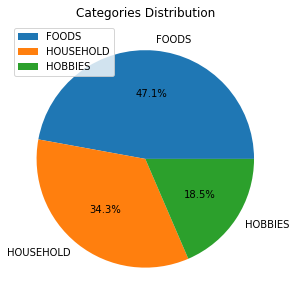

In [27]:
plt.figure(figsize=(15,5))
plt.pie(cat, labels=cat.keys(), autopct='%1.1f%%')
plt.title("Categories Distribution")
plt.legend(loc=2)
plt.show()

In [28]:
store = df.store_id.value_counts().compute()
%time store

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


WI_3    6003481
WI_2    6003481
WI_1    6003481
TX_3    6003481
TX_2    6003481
TX_1    6003481
CA_4    6003481
CA_3    6003481
CA_2    6003481
CA_1    6003481
Name: store_id, dtype: int64

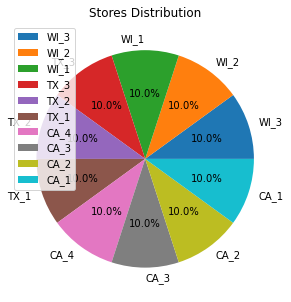

In [29]:
plt.figure(figsize=(15,5))
plt.pie(store, labels=store.keys(), autopct='%1.1f%%')
plt.title("Stores Distribution")
plt.legend(loc=2)
plt.show()

In [30]:
state = df.state_id.value_counts().compute()
state

CA    24013924
WI    18010443
TX    18010443
Name: state_id, dtype: int64

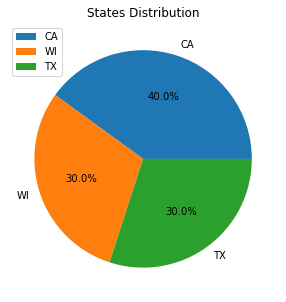

In [31]:
plt.figure(figsize=(15,5))
plt.pie(state, labels=state.keys(), autopct='%1.1f%%')
plt.title("States Distribution")
plt.legend(loc=2)
plt.show()

In [32]:
del cat, state
collected = gc.collect()
print("Garbage Collector collected:", collected, "elements")

Garbage Collector collected: 2385 elements


#### We will divide the final df based in the stores distribution, as it is the most equitable and also we will be able to work fine with the memory usage

In [33]:
dfs_dict = {}
for s in store.keys():
    print("Saving Dataset")
    dfs_dict["df_" + s] = df[df.store_id==s]

for names, values in dfs_dict.items():
    print(names, "size:", len(df),",",len(df.columns))
    values.to_csv(f"OUTPUT/d_{names}.csv", single_file=True)

Saving Dataset
Saving Dataset
Saving Dataset
Saving Dataset
Saving Dataset
Saving Dataset
Saving Dataset
Saving Dataset
Saving Dataset
Saving Dataset
df_WI_3 size: 60034810 , 22
df_WI_2 size: 60034810 , 22
df_WI_1 size: 60034810 , 22
df_TX_3 size: 60034810 , 22
df_TX_2 size: 60034810 , 22
df_TX_1 size: 60034810 , 22
df_CA_4 size: 60034810 , 22
df_CA_3 size: 60034810 , 22
df_CA_2 size: 60034810 , 22
df_CA_1 size: 60034810 , 22


In [34]:
del df
collected = gc.collect()
print(collected)

435
